In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

2024-11-18 23:32:11.427826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731943931.437238   42953 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731943931.439872   42953 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 23:32:11.449426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dir = 'BMEG3103_project/project1_dataset/train'
val_dir = 'BMEG3103_project/project1_dataset/val'
test_dir = 'BMEG3103_project/project1_dataset/test'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

In [4]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 698 images belonging to 2 classes.


In [5]:
# Load the pre-trained EfficientNetB0 model
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

for layer in base_model.layers[:20]:
    layer.trainable = False
for layer in base_model.layers[20:]:
    layer.trainable = True

I0000 00:00:1731943933.070549   42953 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13553 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model with SGD optimizer
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [7]:
# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Define a learning rate scheduler
def cosine_annealing(epoch, lr, total_epochs):
    return 0.5 * lr * (1 + np.cos(np.pi * epoch / total_epochs))

# Define the total number of epochs
total_epochs = 500

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lambda epoch, lr: cosine_annealing(epoch, lr, total_epochs))

# Train the model with learning rate scheduler
history = model.fit(
    train_generator,
    epochs=total_epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)


/home/user/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/500


I0000 00:00:1731943943.599608   43176 service.cc:148] XLA service 0x7fdb58015220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731943943.599635   43176 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2024-11-18 23:32:23.918230: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731943944.629173   43176 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1731943949.315387   43176 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731943949.462101   43176 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731943952.53811

131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 384ms/step - accuracy: 0.4978 - loss: 5.5779 - val_accuracy: 0.7385 - val_loss: 4.7944 - learning_rate: 1.0000e-04
Epoch 2/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 338ms/step - accuracy: 0.5946 - loss: 5.2461 - val_accuracy: 0.7827 - val_loss: 4.8220 - learning_rate: 9.9999e-05
Epoch 3/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 330ms/step - accuracy: 0.6562 - loss: 5.0476 - val_accuracy: 0.7413 - val_loss: 4.7643 - learning_rate: 9.9995e-05
Epoch 4/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 335ms/step - accuracy: 0.6886 - loss: 4.9481 - val_accuracy: 0.7462 - val_loss: 4.7665 - learning_rate: 9.9986e-05
Epoch 5/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 338ms/step - accuracy: 0.6976 - loss: 4.9125 - val_accuracy: 0.7433 - val_loss: 4.7829 - learning_rate: 9.9970e-05
Epoch 6/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 45s 341ms/step - accuracy: 0.7411 - loss: 4.8077 - val_accuracy: 0.7558 - val_loss: 4.6228 - learning_rate: 9.9946e-05
Epoch 7/500
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 337ms/s

In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Get predictions and true labels
test_generator.reset()
preds = model.predict(test_generator)
preds = np.argmax(preds, axis=1)
true_labels = test_generator.classes

# Calculate precision, recall, and confusion matrix
threshold = 0.5  # You can change this value to balance precision and recall
preds = (model.predict(test_generator)[:, 1] > threshold).astype(int)

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 305ms/step - accuracy: 0.7924 - loss: 3.6533
Test Accuracy: 0.8653
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step


In [9]:
test_precision = precision_score(true_labels, preds)
test_recall = recall_score(true_labels, preds)
f1 = f1_score(true_labels, preds)
conf_matrix = confusion_matrix(true_labels, preds)

print(f'F1 Score: {f1:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

F1 Score: 0.9008
Test Precision: 0.8275
Test Recall: 0.9884
Confusion Matrix:
[[177  89]
 [  5 427]]


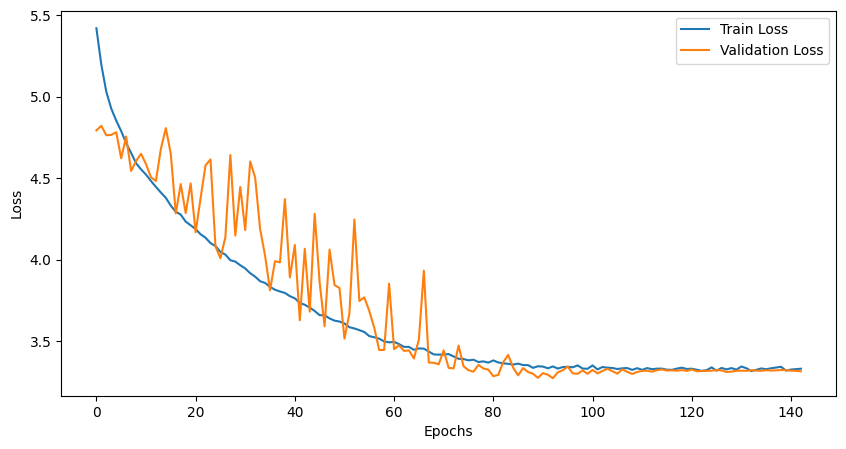

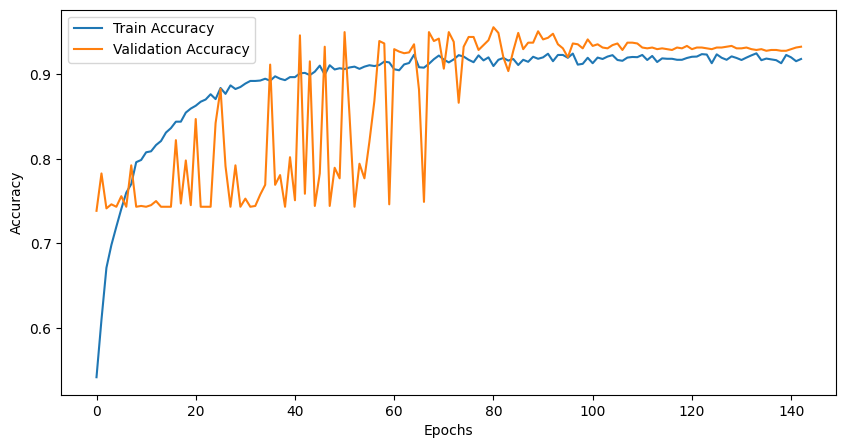

In [10]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation accuracy over epochs
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()